# Онлайн последовательная машина экстремального обучения (OS-ELM) для прогнозирования временных рядов

### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy.linalg import inv, pinv
from sklearn.metrics import r2_score, mean_absolute_error

## Подготовка данныx

### Импортирование данных
Для проекта были взяты данные как в оригинальной статье - количество пассажиров в нью-йоркском такси каждые полчаса

In [2]:
file_path = 'D:\VSCODE\PyPrograms\ELM2\os-elm\data\nyc_taxi.csv'
url = 'https://raw.githubusercontent.com/alexeynau/os-elm/main/data/nyc_taxi.csv'
df = pd.read_csv(url)
df.head(5)

,Unnamed: 0,timestamp,value
0,0,2014-07-01 00:00:00,10844
1,1,2014-07-01 00:30:00,8127
2,2,2014-07-01 01:00:00,6210
3,3,2014-07-01 01:30:00,4656
4,4,2014-07-01 02:00:00,3820


### Отобразим данные на графике

Text(0.5, 0, 'time')

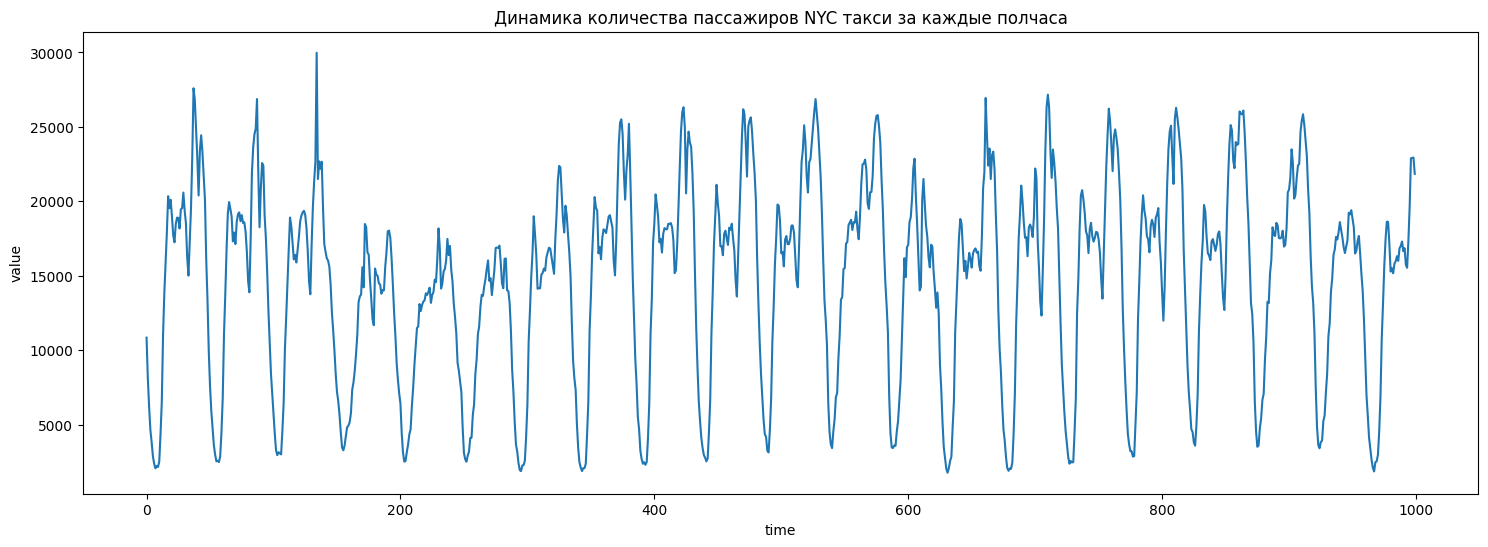

In [3]:
plt.figure(figsize=(18,6))
plt.plot(range(1000), df['value'][:1000])
plt.title('Динамика количества пассажиров NYC такси за каждые полчаса')
plt.ylabel('value')
plt.xlabel('time')

### Убедимся, что в данных не нет пропусков

In [4]:
df.isnull().sum()

Unnamed: 0    0
timestamp     0
value         0
dtype: int64

### Нормализуем данные с помощью z-масштабирования

In [5]:
stdSeq = float(np.std(df[['value']]))
meanSeq = float(np.mean(df['value']))
print(f'std: {stdSeq}, mean {meanSeq}')
df['z-scaled'] = StandardScaler().fit_transform(df[['value']])
df.head(5)

std: 6939.15958404066, mean 15137.569379844961


,Unnamed: 0,timestamp,value,z-scaled
0,0,2014-07-01 00:00:00,10844,-0.618745
1,1,2014-07-01 00:30:00,8127,-1.010291
2,2,2014-07-01 01:00:00,6210,-1.286549
3,3,2014-07-01 01:30:00,4656,-1.510496
4,4,2014-07-01 02:00:00,3820,-1.630971


### Подготовим пары предикторов и откликов
Для этого преобразуем данные с помощью метода скользящего окна

In [6]:
def sliding_window(series, period):
    X = np.zeros(shape=(len(series) - period, period ))
    for i in range(len(series) - period):
        X[i] = (np.array(series[i:i+period]))

    return X


X = sliding_window(df['z-scaled'], 100)
Y = np.array(df['z-scaled'][100:])
# Убедимся, что окно работает правильно
print(X[:2, :4], '\n', X[-2:, :4])

[[-0.61874487 -1.01029084 -1.28654908 -1.51049551]
 [-1.01029084 -1.28654908 -1.51049551 -1.63097119]] 
 [[1.1630271  1.1601449  1.08088458 0.91703189]
 [1.1601449  1.08088458 0.91703189 0.80433813]]


In [8]:
print('X-shape: ', X.shape, '\nY-shape: ', Y.shape)

X-shape:  (10220, 100) 
Y-shape:  (10220,)


## Реализация OS-ELM

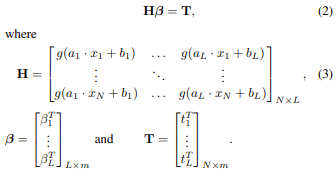

В качестве функции активации выбрана сигмоидальная функция:
$$ \sigma (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$ 

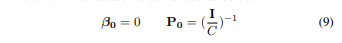

image.png

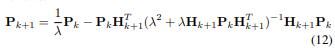

In [10]:
class OSELM:
    def __init__(self, nInputs, nOutputs, numHiddenNeurons, forgettingFactor=1, gamma = 0.0001):

        self.numHiddenNeurons = numHiddenNeurons
        self.lamb = forgettingFactor

        # Веса и смещение выбираются случайным образом в интервале [-1; 1]
        self.alpha = np.random.random((self.numHiddenNeurons, nInputs)) * 2 - 1 
        self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1

        self.beta = np.zeros((self.numHiddenNeurons, nOutputs)) # Формула 9
        self.P = inv(gamma*np.eye(self.numHiddenNeurons)) # Формула 9


    def compute_h(self, features):       
        return self.sigmoid(features @ self.alpha.T  + self.bias)


    def sigmoid(self, features):
        return 1.0 / (1.0 + np.exp(-features))


    def fit(self, features, targets):
        features = np.array(features)
        targets = np.array(targets)
    
        H = self.compute_h(features)

        k = 1/self.lamb
        self.P = k * self.P - self.P @ H.T @ pinv(self.lamb**2 + self.lamb * H @ self.P @ H.T) @ H @ self.P # Формула 12

        self.beta = self.beta + self.P @ H.T @ (targets - H @ self.beta) # Формула 10
  
    def predict(self, features):
        H = self.compute_h(features)
        prediction = H @ self.beta # Формула 2
        return prediction

## Обучение и прогнозирование

In [11]:
predictions = []
targets = Y[:-1]
oselm = OSELM(100, 1, 100, forgettingFactor=0.996)
for i in range(len(df)-101):
    oselm.fit(X[i], Y[i])
    prediction = oselm.predict(X[i+1])

    predictions.append(prediction[0])

In [12]:
len(predictions), len(targets)

(10219, 10219)

## Результаты

Приведём спрогнозированные и целевые значения к абсолютным значениям

In [13]:
predictions = np.array(predictions)
predictions = predictions * stdSeq + meanSeq
targets = targets * stdSeq + meanSeq

Изучим результаты, отобразив их на графике

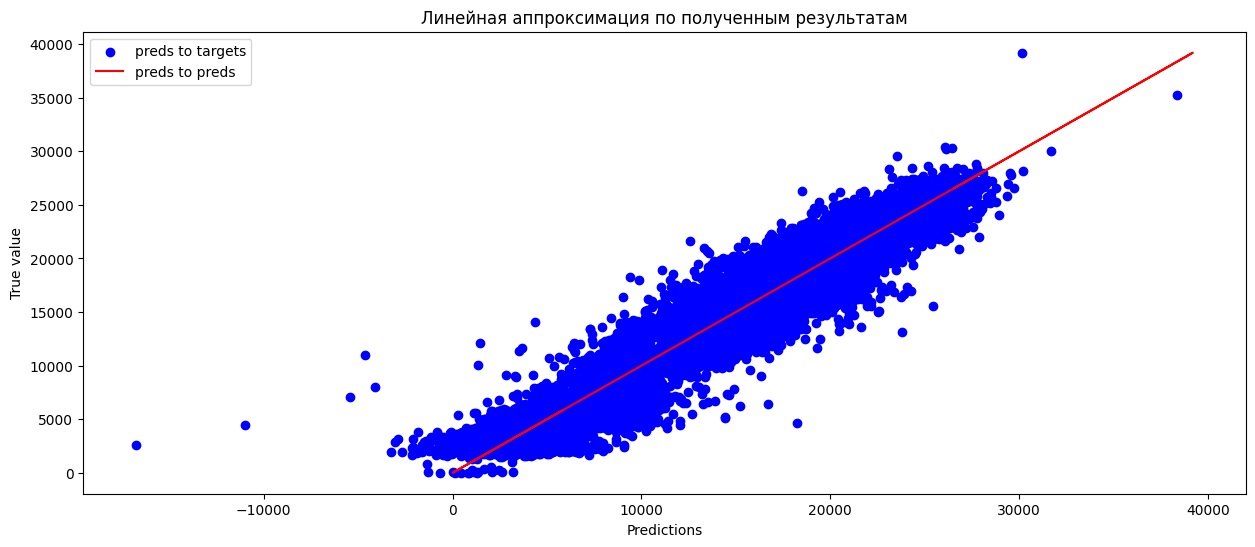

In [14]:
plt.figure(figsize=(15, 6))
plt.scatter(predictions, targets, c='b', label='preds to targets')
plt.plot(targets, targets, c='r', label='preds to preds')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.title('Линейная аппроксимация по полученным результатам')
plt.legend()

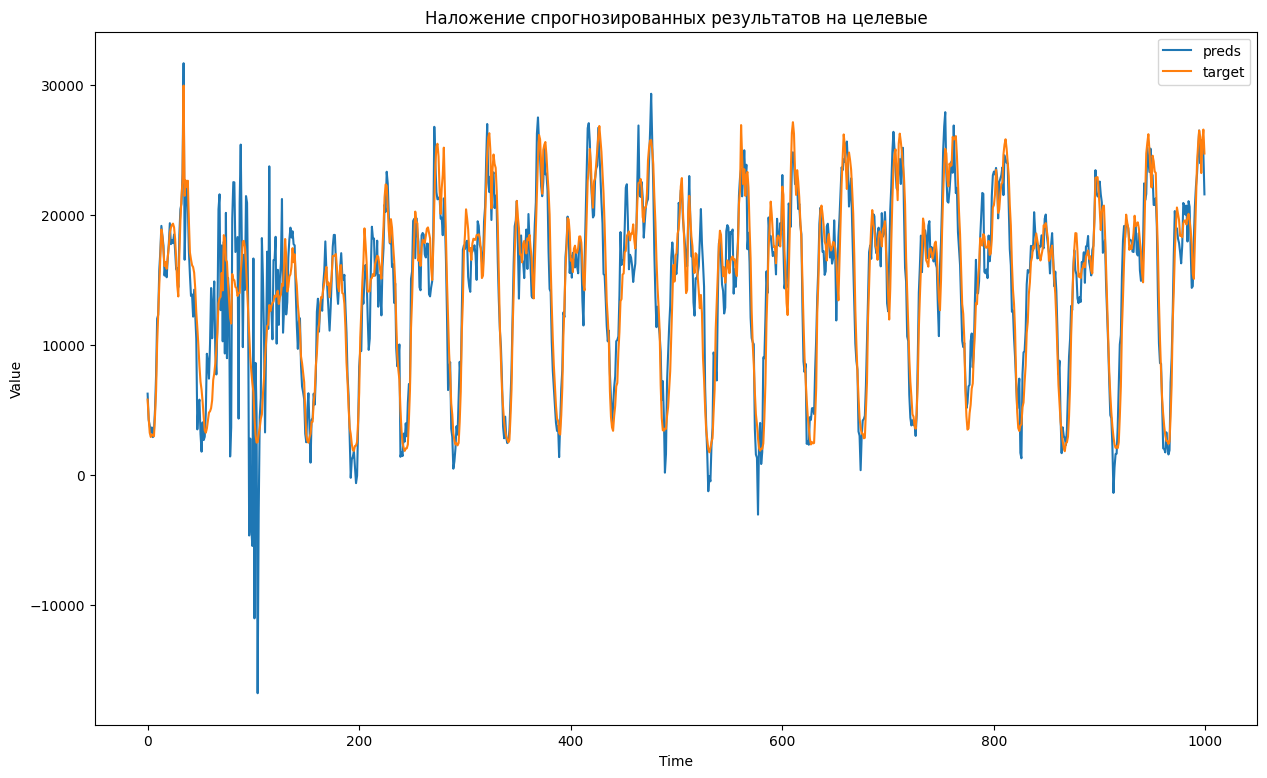

In [15]:
plt.figure(figsize=(15, 9))
plt.plot(range(1000), predictions[:1000], label = 'preds')
plt.plot(range(1000), targets[:1000], label='target')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Наложение спрогнозированных результатов на целевые')
plt.legend()

Коэффициент детерминации для полученной модели:

In [16]:
r2_score(targets, predictions)

0.903607773035574

Среднее абсолютной ошибки:

In [17]:
mean_absolute_error(targets, predictions)

1668.7420322994108

### Найдём оптимальные параметры для OS-ELM

In [18]:
numsHiddenNeurons = [25, 50, 75, 100]
forgettingFactors = [0.950, 0.975, 0.990, 1]
r2_scores = []
maes = []
for num in numsHiddenNeurons:
    for ff in forgettingFactors:

        predictions = []
        targets = Y[:-1]
        oselm = OSELM(100, 1, num, forgettingFactor=ff)
        for i in range(len(df)-101):
            oselm.fit(X[i], Y[i])
            prediction = oselm.predict(X[i+1])

            predictions.append(prediction[0])
        
        predictions = np.array(predictions)
        predictions = predictions * stdSeq + meanSeq
        targets = targets * stdSeq + meanSeq

        r2_scores.append(r2_score(targets, predictions))
        maes.append(mean_absolute_error(targets, predictions))
        

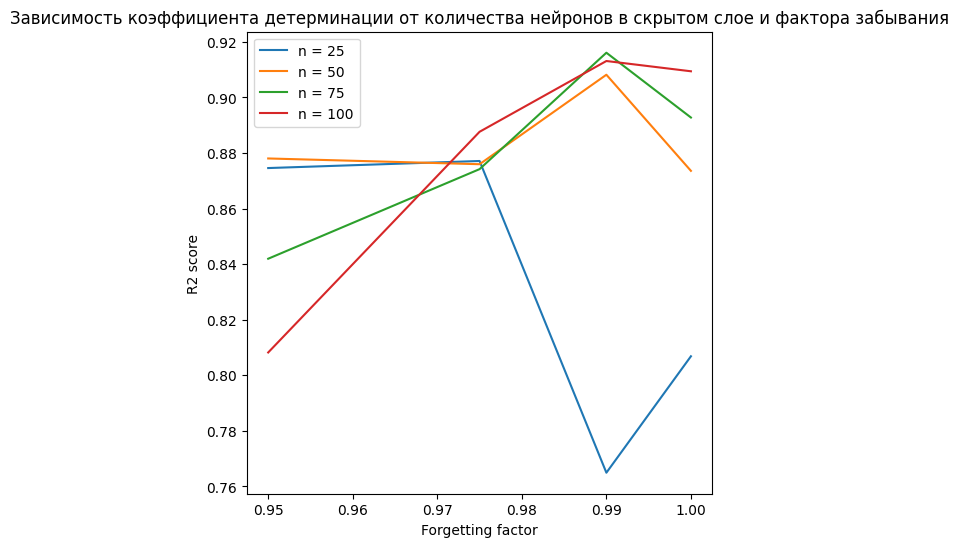

In [19]:
plt.figure(figsize=(6,6))
plt.title(f'Зависимость коэффициента детерминации от количества нейронов в скрытом слое и фактора забывания')
plt.xlabel('Forgetting factor')
plt.ylabel('R2 score')
for i in range(4):
    plt.plot(forgettingFactors, r2_scores[i*4:(i+1) * 4], label=f'n = {numsHiddenNeurons[i]}')
plt.legend()

Максимальный коэффициент детерминации при\
n = 75\
FF = 0,99


In [20]:
max(r2_scores)

0.9161127308776539

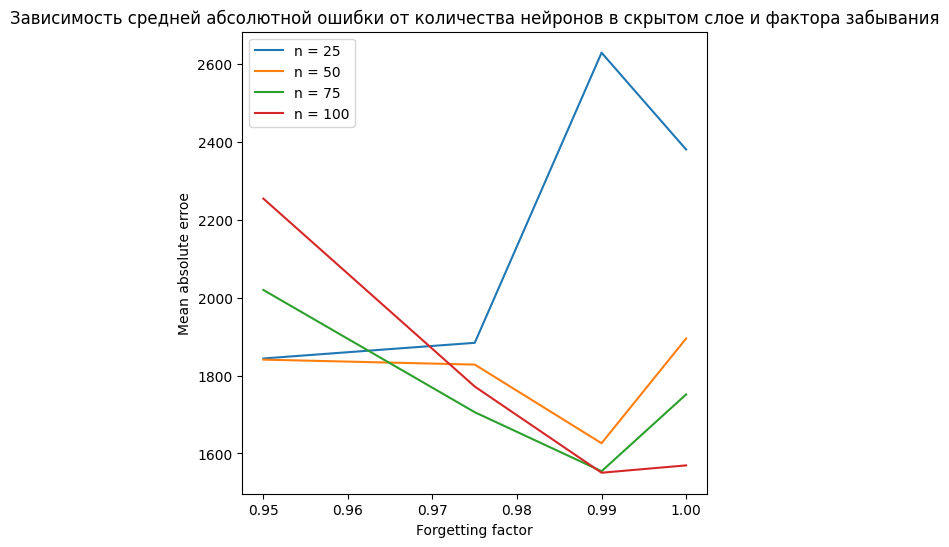

In [21]:
plt.figure(figsize=(6,6))
plt.title(f'Зависимость средней абсолютной ошибки от количества нейронов в скрытом слое и фактора забывания')
plt.xlabel('Forgetting factor')
plt.ylabel('Mean absolute erroe')
for i in range(4):
    plt.plot(forgettingFactors, maes[i*4:(i+1) * 4], label=f'n = {numsHiddenNeurons[i]}')
plt.legend()

In [145]:
min(maes)

1654.2334483144848

In [22]:
forgettingFactors = [0.89, 0.990, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
r2_scores = []
maes = []
for ff in forgettingFactors:

    predictions = []
    targets = Y[:-1]
    oselm = OSELM(100, 1, 100, forgettingFactor=ff)
    for i in range(len(df)-101):
        oselm.fit(X[i], Y[i])
        prediction = oselm.predict(X[i+1])

        predictions.append(prediction[0])
    
    predictions = np.array(predictions)
    predictions = predictions * stdSeq + meanSeq
    targets = targets * stdSeq + meanSeq

    r2_scores.append(r2_score(targets, predictions))
    maes.append(mean_absolute_error(targets, predictions))
        

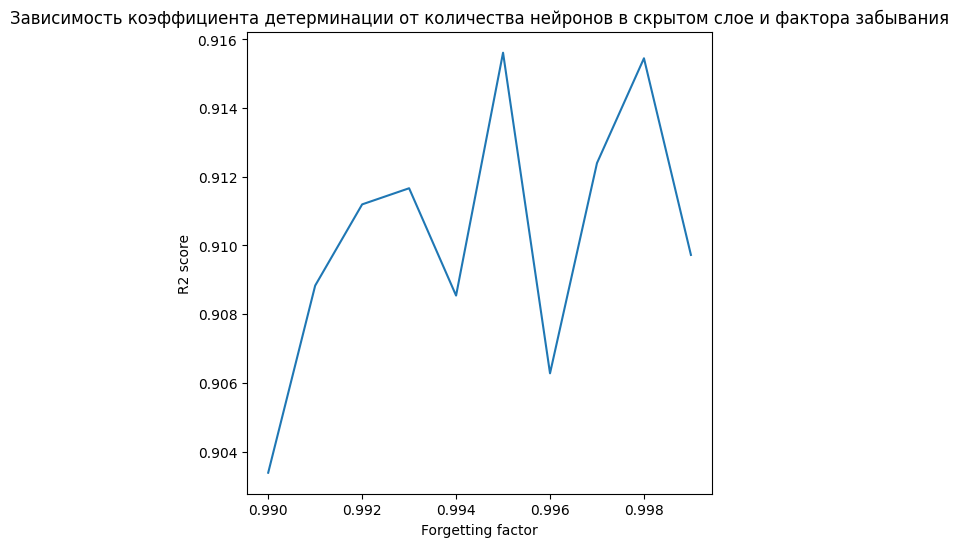

In [25]:
plt.figure(figsize=(6,6))
plt.title(f'Зависимость коэффициента детерминации от количества нейронов в скрытом слое и фактора забывания')
plt.xlabel('Forgetting factor')
plt.ylabel('R2 score')
plt.plot(forgettingFactors[1:], r2_scores[1:])

## Вывод
Оптимальный прогноз с помощью машины экстремального обучения (OS-ELM) достигается при 50 и более нейронах в скрытом слое и факторе забывания равному 0,99.